### Coordinates 100 shapley points - 6 class training

#### Environment preparation

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
print(f"Dane będą wczytywane z: {COLAB_ROOT}")

Mounted at /content/drive
Dane będą wczytywane z: /content/drive/MyDrive/PainRecognitionProject/


In [2]:
import os

# Przejście do katalogu głównego
%cd /content

# Klonowanie repo
!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [3]:
# Upewnij się, że nazwa użytkownika i repozytorium są poprawne
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

# Tworzenie poprawnego adresu URL (format: https://<TOKEN>@github.com/...)
REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

# Klonowanie
!git clone {REPO_URL}

# Wejście do katalogu
%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 212 (delta 90), reused 159 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (212/212), 10.51 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/automatic-pain-recognition


In [ ]:
# Instalacja wymaganych bibliotek
!pip install -r requirements.txt

In [5]:
import sys
import os

# Dodaj katalog główny projektu do ścieżki systemowej
sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### Coordinates 100 shapley points - 6 class training

In [6]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from training_utils.preprocessed_dataset import PreprocessedDataset
from training_utils.train import Trainer
from training_utils.evaluate import Evaluator
from models.Bi_LSTM import SequenceModel

#### Hiperparameters

In [7]:
MAX_SEQUENCE_LENGTH = 37
NUM_FEATURES = 300
NUM_CLASSES = 6
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.00005
DROPOUT_PROB = 0.4
WEIGHT_DECAY = 0.005
SCHEDULER_FACTOR = 0.8

#### Data preparation

In [8]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/RAVDESS_processed_478_xyz_frontalized/')
MODEL_SAVE_DIR = os.path.join(COLAB_ROOT, 'models/')
LOCAL_PROCESSED_DATA_ROOT = '/content/temp_data/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print("Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...")
if os.path.exists(LOCAL_PROCESSED_DATA_ROOT):
    shutil.rmtree(LOCAL_PROCESSED_DATA_ROOT)
try:
    shutil.copytree(PROCESSED_DATA_DIR, LOCAL_PROCESSED_DATA_ROOT)
    print("✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)")
    CURRENT_DATA_DIR = LOCAL_PROCESSED_DATA_ROOT

except Exception as e:
    print(f"❌ Błąd kopiowania danych (sprawdź, czy dane są zamontowane): {e}")
    print("Używam danych bezpośrednio z Drive (może się zawiesić).")
    CURRENT_DATA_DIR = PROCESSED_DATA_DIR

Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...
✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)


In [14]:
best_100_landmarks = np.load('/content/drive/MyDrive/PainRecognitionProject/data/top_100_important_landmarks_emotions.npy')

feature_indices_x = best_100_landmarks * 3
feature_indices_y = best_100_landmarks * 3 + 1
feature_indices_z = best_100_landmarks * 3 + 2

# Interleave to get [X1, Y1, Z1, X2, Y2, Z2, ...]
best_300_features = np.stack([feature_indices_x, feature_indices_y, feature_indices_z], axis=1).flatten()


In [16]:
train_dataset = PreprocessedDataset(
    'train',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

val_dataset = PreprocessedDataset(
    'val',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

test_dataset = PreprocessedDataset(
    'test',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

In [17]:
def preview_single(dataset, idx=0, timesteps_to_show=3, features_to_show=8):
    x, y = dataset[idx]
    print(f"\nSingle sample idx={idx} from split={dataset.dataset_name}")
    print(f"x shape: {tuple(x.shape)}, y: {y}")
    print(np.round(x[:timesteps_to_show, :features_to_show], 4))

preview_single(train_dataset, 0)
preview_single(val_dataset, 0)
preview_single(test_dataset, 0)


Single sample idx=0 from split=train
x shape: (37, 300), y: 0
tensor([[0.1200, 0.1258, 0.0998, 0.0743, 0.2147, 0.0840, 0.1153, 0.0871],
        [0.1213, 0.1188, 0.1005, 0.0734, 0.2076, 0.0847, 0.1169, 0.0810],
        [0.1207, 0.1173, 0.1008, 0.0729, 0.2075, 0.0855, 0.1164, 0.0797]])

Single sample idx=0 from split=val
x shape: (37, 300), y: 0
tensor([[0.1175, 0.1648, 0.0948, 0.0828, 0.2491, 0.0832, 0.1096, 0.1200],
        [0.1184, 0.1623, 0.0920, 0.0829, 0.2444, 0.0803, 0.1108, 0.1176],
        [0.1171, 0.1598, 0.0925, 0.0813, 0.2437, 0.0813, 0.1098, 0.1149]])

Single sample idx=0 from split=test
x shape: (37, 300), y: 0
tensor([[0.1082, 0.1569, 0.0883, 0.0776, 0.2421, 0.0777, 0.1013, 0.1135],
        [0.1057, 0.1619, 0.0862, 0.0752, 0.2457, 0.0760, 0.0990, 0.1176],
        [0.1065, 0.1618, 0.0880, 0.0761, 0.2491, 0.0784, 0.0997, 0.1173]])


In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in train_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in val_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in test_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

torch.Size([16, 37, 300]) torch.Size([16])
torch.Size([16, 37, 300]) torch.Size([16])
torch.Size([16, 37, 300]) torch.Size([16])


#### Model preparation

In [19]:
model = SequenceModel(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_PROB).to(DEVICE)

#### Training

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=SCHEDULER_FACTOR,
    patience=10,
    min_lr=1e-7
)

model_name = 'testing_new_code_emotions_100_coordinates_6_classes.pt'
model_filepath = os.path.join(MODEL_SAVE_DIR, model_name)

In [21]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=DEVICE,
    model_save_path=model_filepath,
    num_epochs=NUM_EPOCHS,
    monitor='val_acc',  # or 'val_loss'
    minimize_monitor=False,
    save_best_only=True
)

In [22]:
trainer.print_training_config()



🚀 TRAINING CONFIGURATION

--- Model Architecture ---
  Model Type            : SequenceModel
  Input Features        : 300
  Hidden Size           : 128
  Num Layers            : 2
  Bidirectional         : True
  Dropout (LSTM)        : 0.4
  Num Parameters        : 837126

--- Optimizer & Regularization ---
  Optimizer             : AdamW
  Learning Rate (LR)    : 5e-05
  Weight Decay (L2)     : 0.005

--- Training Flow ---
  Batch Size            : 16
  Num Epochs            : 200
  Device                : cuda



In [23]:
final_model_path, best_model_path, history = trainer.fit()
print(f"Final model saved to: {final_model_path}")
if best_model_path:
    print(f"Best model saved to: {best_model_path}")


Starting training for 200 epochs on cuda
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_coordinates_6_classes.pt (metric=0.1671)
Epoch 1/200 | Time 2.50s | Train loss 1.7925 | Train acc 0.1615 | Val loss 1.7905 | Val acc 0.1671
Epoch 2/200 | Time 1.57s | Train loss 1.7892 | Train acc 0.1986 | Val loss 1.7887 | Val acc 0.1671
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_coordinates_6_classes.pt (metric=0.2559)
Epoch 3/200 | Time 1.77s | Train loss 1.7876 | Train acc 0.1986 | Val loss 1.7851 | Val acc 0.2559
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_coordinates_6_classes.pt (metric=0.3420)
Epoch 4/200 | Time 1.69s | Train loss 1.7698 | Train acc 0.2546 | Val loss 1.7095 | Val acc 0.3420
Epoch 5/200 | Time 1.46s | Train loss 1.5640 | Train acc 0.3092 | Val loss 1.5587 | Val acc 0.3107
Epoch 6/200 | Tim

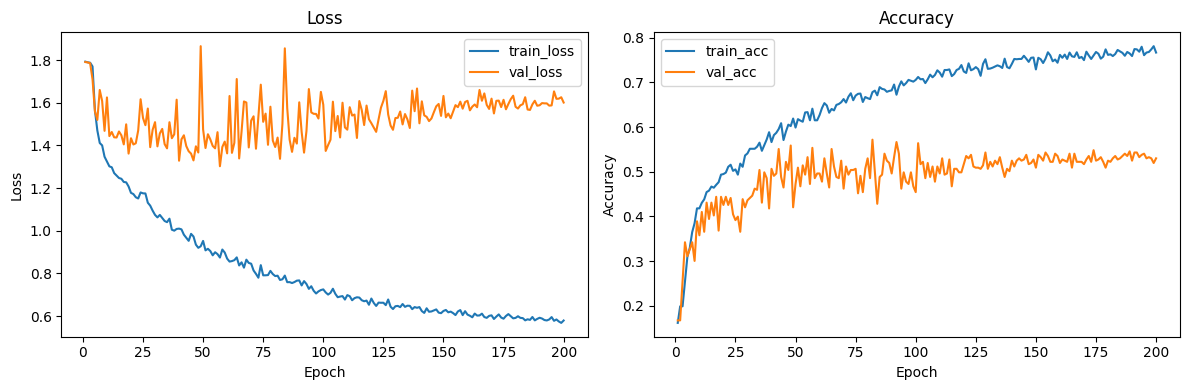

In [24]:
trainer.plot_history()

#### Evaluate

In [25]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE), strict=False)

<All keys matched successfully>

In [26]:
evaluator = Evaluator(model, test_loader, device=DEVICE, model_name=model_name, num_classes=NUM_CLASSES)


In [27]:
loss, acc, labels, preds = evaluator.evaluate_epoch()


WYNIKI OCENY DLA MODELU: testing_new_code_emotions_100_coordinates_6_classes.pt
Test Loss: 1.7167
Test Accuracy: 0.4271

--- Szczegółowy Raport Klasyfikacji ---
              precision    recall  f1-score   support

     Klasa 0       0.81      0.53      0.64        64
     Klasa 1       1.00      0.47      0.64        64
     Klasa 2       0.31      0.47      0.37        64
     Klasa 3       0.78      0.44      0.56        64
     Klasa 4       0.22      0.22      0.22        64
     Klasa 5       0.24      0.44      0.31        64

    accuracy                           0.43       384
   macro avg       0.56      0.43      0.46       384
weighted avg       0.56      0.43      0.46       384

Confusion matrix:
 [[34  0 15  0 13  2]
 [ 8 30  6  0  0 20]
 [ 0  0 30  2 12 20]
 [ 0  0  4 28 22 10]
 [ 0  0 11  4 14 35]
 [ 0  0 31  2  3 28]]
